# BUSINESS PROBLEM & UNDERSTANDING
STAKEHOLDER:SPOTIFY
PROBLEM: Spotify is launch a new Movie Divison. We are contracted Data Scientist tasked with  creating a reccomendation system . We want to compete with other streaming platforms such as Netflix, Hulu, Amazon Prime. Since they are new to the market, they want to ensure that their Reccomendation System is accurate and reliable.   

 Your task is to:

Build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.
The MovieLens dataset is a "classic" recommendation system dataset, that is used in numerous academic papers and machine learning proofs-of-concept. You will need to create the specific details about how the user will provide their ratings of other movies, in addition to formulating a more specific business problem within the general context of "recommending movies".




# Data Preparation

In [47]:
#Importing Libraries 
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import surprise
from surprise.prediction_algorithms import *
import pandas as pd
import numpy as np
from datetime import datetime

from collections import Counter

from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [48]:
# Reading in datasets
df_movies = pd.read_csv('data/movies.csv')
df_links = pd.read_csv('data/links.csv')
df_ratings = pd.read_csv('data/ratings.csv')
df_tags = pd.read_csv('data/tags.csv')

In [49]:
#looking at each indivdual csv before merging.
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [50]:
df_links.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


This dataset(df_links) contains links to each movie imdb and tmbd website ratings. Which is not applicable in the current scope of our business problem. 

In [51]:
df_ratings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [52]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [53]:
df_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [54]:
# Checking for any movie duplicated in the dataset and we get % movies back
df_movies[df_movies['title'].duplicated() == True]

,movieId,title,genres
5601,26958,Emma (1996),Romance
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


Merging Dataset to one Pandas Database.
Combining the Movies, Ratings, Tags Dataset. Not including Links dataset due to its non relevance to the business problem.

In [55]:

movie_combo = pd.merge(df_movies, df_ratings, left_on='movieId', right_on='movieId', how='left')

movie_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100854 entries, 0 to 100853
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100854 non-null  int64  
 1   title      100854 non-null  object 
 2   genres     100854 non-null  object 
 3   userId     100836 non-null  float64
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 5.4+ MB


We can see there are missing values in rating and timestamps. Which will need to be addressed to ensure the algorithm will run sucessfully.

In [56]:
movie_combo.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09


In [57]:
movie_combo.drop(['genres'], axis=1)

,movieId,title,userId,rating,timestamp
0,1,Toy Story (1995),1.0,4.0,9.649827e+08
1,1,Toy Story (1995),5.0,4.0,8.474350e+08
2,1,Toy Story (1995),7.0,4.5,1.106636e+09
3,1,Toy Story (1995),15.0,2.5,1.510578e+09
4,1,Toy Story (1995),17.0,4.5,1.305696e+09
...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),184.0,4.0,1.537109e+09
100850,193583,No Game No Life: Zero (2017),184.0,3.5,1.537110e+09
100851,193585,Flint (2017),184.0,3.5,1.537110e+09
100852,193587,Bungo Stray Dogs: Dead Apple (2018),184.0,3.5,1.537110e+09


Next we want to fill in the missing timestamp vales with the mode of timestamp

In [12]:
# Filling in missing timestamp values with the mode. 
movie_combo['timestamp'] = movie_combo['timestamp'].fillna(movie_combo['timestamp'].mode()[0])
movie_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100854 entries, 0 to 100853
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100854 non-null  int64  
 1   title      100854 non-null  object 
 2   genres     100854 non-null  object 
 3   userId     100836 non-null  float64
 4   rating     100836 non-null  float64
 5   timestamp  100854 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 5.4+ MB


In [13]:
# Filling in missing rating values with the mode. 
movie_combo['rating'] = movie_combo['rating'].fillna(movie_combo['rating'].mode()[0])
movie_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100854 entries, 0 to 100853
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100854 non-null  int64  
 1   title      100854 non-null  object 
 2   genres     100854 non-null  object 
 3   userId     100836 non-null  float64
 4   rating     100854 non-null  float64
 5   timestamp  100854 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 5.4+ MB


Next in our process we want to convert the timestamp column to datetime format for our algorithm. First we have to convert timestamp from float type to interger.

In [14]:
#converting timsestamp column to integers
movie_combo['timestamp'] = movie_combo['timestamp'].astype(int)

In [15]:
movie_combo.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1305696483


In [16]:
#checking for assurance
movie_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100854 entries, 0 to 100853
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100854 non-null  int64  
 1   title      100854 non-null  object 
 2   genres     100854 non-null  object 
 3   userId     100836 non-null  float64
 4   rating     100854 non-null  float64
 5   timestamp  100854 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 5.4+ MB


In [17]:
movie_combo.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1305696483


In [18]:
# converting timestamp to datetime index format


movie_combo['timestamp'] = movie_combo['timestamp'].apply(lambda t: datetime.utcfromtimestamp(t*1).strftime('%Y-%m-%d'))
movie_combo.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,2000-07-30
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1996-11-08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,2005-01-25
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,2017-11-13
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,2011-05-18


In [19]:
# Converting duplicate titles to the lower of 'movieId' duplicates as the lower value had more user ratings in each instance.
# This step was performed after merging the dateframes as we didn't want to lose data before the merge.

for idx, row in movie_combo.iterrows():
    # Emma (1996)
    if  movie_combo.loc[idx,'movieId'] == 26958:
        movie_combo.loc[idx,'movieId'] = 838
    # War of the Worlds (2005)
    elif movie_combo.loc[idx,'movieId'] == 64997:
        movie_combo.loc[idx,'movieId'] = 34048
    # Confessions of a Dangerous Mind (2002)
    elif movie_combo.loc[idx,'movieId'] == 144606:
        movie_combo.loc[idx,'movieId'] = 6003
    # Eros (2004)
    elif movie_combo.loc[idx,'movieId'] == 147002:
        movie_combo.loc[idx,'movieId'] = 32600
    # Saturn 3 (1980)
    elif movie_combo.loc[idx,'movieId'] == 168358:
        movie_combo.loc[idx,'movieId'] = 2851
    else:
        continue


In [20]:
# Verify corrections (Should be blank)
movie_combo[(movie_combo['movieId'] == 26958 | 64997 | 144606 | 147002 | 168358)]

,movieId,title,genres,userId,rating,timestamp


# EDA / Visualizations

In [58]:
movie_combo.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09


array([[<AxesSubplot:title={'center':'movieId'}>,
        <AxesSubplot:title={'center':'userId'}>],
       [<AxesSubplot:title={'center':'rating'}>,
        <AxesSubplot:title={'center':'timestamp'}>]], dtype=object)

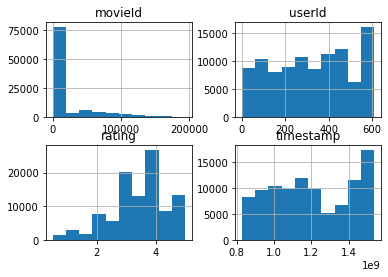

In [59]:
movie_combo.hist() #looking at the distributions pf the data

In [61]:
print('Number of users: ',len(movie_combo.userId.unique()))
print('Number of movie titles: ',len(movie_combo.movieId.unique()))
print('Number of ratings: ' ,movie_combo.shape[0])


Number of users:  611
Number of movie titles:  9742
Number of ratings:  100854


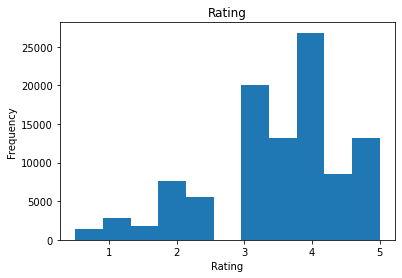

In [68]:
# Distribution of ratings
movie_combo.rating.plot.hist(bins=11)
plt.xlabel('Rating')
plt.title('Rating');

looking at the disribtuion of rating, we can see a lot of ratings between 3- 5 stars. 

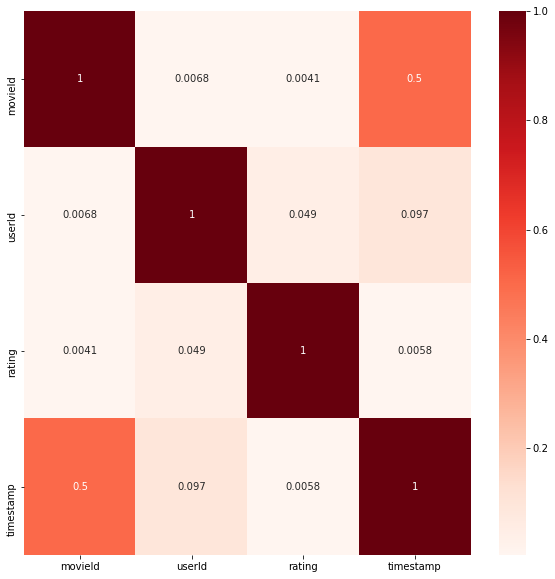

In [72]:
# heat map to display any correlations within the dataset.
corr = movie_combo.corr().abs()
fig, ax=plt.subplots(figsize=(10,10))
sns.heatmap(corr, cmap='Reds', annot=True);

# Train Test Split

In [21]:

data = movie_combo[['userId', 'movieId', 'rating']]
reader = Reader(line_format='user item rating', sep=',',rating_scale=(0.5, 5))
data = Dataset.load_from_df(data,reader =reader)
# train-test-split
#trainset, testset = train_test_split(data, test_size=.2)


trainset, testset = surprise.model_selection.train_test_split(data, test_size=0.2, random_state=42)



# Baseline/ Dummy Model  KNN model

Baseline model with no paramater specified

In [22]:
knn_model = KNNBasic().fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [23]:
knn_model

In [24]:
knn_model.sim

array([[1.        , 0.54183267, 0.39669421, ..., 0.        , 0.        ,
        0.        ],
       [0.54183267, 1.        , 0.3813415 , ..., 0.        , 0.        ,
        0.        ],
       [0.39669421, 0.3813415 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [25]:
knn_model.test(testset)


[Prediction(uid=184.0, iid=105653, r_ui=4.0, est=4.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=105.0, iid=5617, r_ui=4.0, est=3.912228816223046, details={'actual_k': 18, 'was_impossible': False}),
 Prediction(uid=182.0, iid=5423, r_ui=4.0, est=2.491690451715915, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=288.0, iid=7293, r_ui=3.0, est=3.57912473658739, details={'actual_k': 38, 'was_impossible': False}),
 Prediction(uid=75.0, iid=2628, r_ui=1.0, est=3.0049754540165092, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=606.0, iid=2541, r_ui=4.0, est=3.3568710795207433, details={'actual_k': 34, 'was_impossible': False}),
 Prediction(uid=79.0, iid=858, r_ui=5.0, est=4.643473312584755, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=288.0, iid=2391, r_ui=4.0, est=3.586720929085241, details={'actual_k': 17, 'was_impossible': False}),
 Prediction(uid=182.0, iid=6215, r_ui=3.0, est=3.0, details={'actual_k':

In [26]:
surprise.accuracy.mae(knn_model.test(testset))

MAE:  0.7320


0.7320462148231864

In [27]:
print(accuracy.rmse(knn_model.test(testset)))

RMSE: 0.9553
0.9552557789041456


Our Baseline model got a RMSE of 95%  and MAE of 73%.  We want to see if we produce a better model with either trying differnt model or editing the pyrameters. 

# SVD Model

In [28]:
svd = SVD()
svd.fit(trainset)

In [29]:
predictions = svd.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8808


0.8807773684641851

In [30]:
predictions[:10]

[Prediction(uid=184.0, iid=105653, r_ui=4.0, est=3.534646611903019, details={'was_impossible': False}),
 Prediction(uid=105.0, iid=5617, r_ui=4.0, est=4.353982354639739, details={'was_impossible': False}),
 Prediction(uid=182.0, iid=5423, r_ui=4.0, est=3.250757786629085, details={'was_impossible': False}),
 Prediction(uid=288.0, iid=7293, r_ui=3.0, est=3.0259756803668405, details={'was_impossible': False}),
 Prediction(uid=75.0, iid=2628, r_ui=1.0, est=2.0721094243708498, details={'was_impossible': False}),
 Prediction(uid=606.0, iid=2541, r_ui=4.0, est=3.327684336072985, details={'was_impossible': False}),
 Prediction(uid=79.0, iid=858, r_ui=5.0, est=4.713170696394449, details={'was_impossible': False}),
 Prediction(uid=288.0, iid=2391, r_ui=4.0, est=3.2060484961732056, details={'was_impossible': False}),
 Prediction(uid=182.0, iid=6215, r_ui=3.0, est=3.4395294576653277, details={'was_impossible': False}),
 Prediction(uid=313.0, iid=2302, r_ui=1.0, est=3.2184572574907904, details={'wa

In [31]:
user = 5
item = 100
svd.predict(user, item)

Prediction(uid=5, iid=100, r_ui=None, est=3.032128344529806, details={'was_impossible': False})

# MNF MODEL

In [32]:
model3 = NMF().fit(trainset)


In [33]:
model3.test(testset)

[Prediction(uid=184.0, iid=105653, r_ui=4.0, est=3.818514505286057, details={'was_impossible': False}),
 Prediction(uid=105.0, iid=5617, r_ui=4.0, est=4.403556296591436, details={'was_impossible': False}),
 Prediction(uid=182.0, iid=5423, r_ui=4.0, est=2.214262091725082, details={'was_impossible': False}),
 Prediction(uid=288.0, iid=7293, r_ui=3.0, est=3.440296118914158, details={'was_impossible': False}),
 Prediction(uid=75.0, iid=2628, r_ui=1.0, est=2.2889991493088013, details={'was_impossible': False}),
 Prediction(uid=606.0, iid=2541, r_ui=4.0, est=3.4875137342981017, details={'was_impossible': False}),
 Prediction(uid=79.0, iid=858, r_ui=5.0, est=4.4822174434807405, details={'was_impossible': False}),
 Prediction(uid=288.0, iid=2391, r_ui=4.0, est=3.4661654577436587, details={'was_impossible': False}),
 Prediction(uid=182.0, iid=6215, r_ui=3.0, est=2.789526776932422, details={'was_impossible': False}),
 Prediction(uid=313.0, iid=2302, r_ui=1.0, est=3.6626330229279294, details={'wa

In [34]:
surprise.accuracy.mae(model3.test(testset))
surprise.accuracy.rmse(model3.test(testset))

MAE:  0.7092
RMSE: 0.9270


0.9270155933161475

In [35]:
sim_options = {'name': 'MSD', 'user_based':False}

knn_model2 = KNNBasic(k = 4, min_k =1, sim_options = sim_options).fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [36]:
knn_model2.sim

array([[1.        , 0.66666667, 0.61538462, ..., 1.        , 0.        ,
        0.        ],
       [0.66666667, 1.        , 0.54545455, ..., 0.        , 0.        ,
        0.5       ],
       [0.61538462, 0.54545455, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.5       , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [37]:
knn_model2.test(testset)

[Prediction(uid=184.0, iid=105653, r_ui=4.0, est=4.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=105.0, iid=5617, r_ui=4.0, est=4.25, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=182.0, iid=5423, r_ui=4.0, est=3.0, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=288.0, iid=7293, r_ui=3.0, est=3.0, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=75.0, iid=2628, r_ui=1.0, est=3.4750201073639713, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=606.0, iid=2541, r_ui=4.0, est=3.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=79.0, iid=858, r_ui=5.0, est=5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=288.0, iid=2391, r_ui=4.0, est=2.625, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=182.0, iid=6215, r_ui=3.0, est=3.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=313.0, iid=2302, r_ui=1.0, est=2.5, detail

In [38]:
surprise.accuracy.mae(knn_model.test(testset))
print(accuracy.rmse(knn_model.test(testset)))

MAE:  0.7320
RMSE: 0.9553
0.9552557789041456


# KNN MODEL TUNED

In [39]:
knn_model_tuned = KNNBasic(sim_options={'n_neighbors': 3, 'leaf_size': 5, 'n_jobs': -1}).fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [40]:
knn_model_tuned.test

<bound method AlgoBase.test of <surprise.prediction_algorithms.knns.KNNBasic object at 0x7ff8727bf6d0>>

In [41]:
knn_model_tuned.test(testset)

[Prediction(uid=184.0, iid=105653, r_ui=4.0, est=4.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=105.0, iid=5617, r_ui=4.0, est=3.912228816223046, details={'actual_k': 18, 'was_impossible': False}),
 Prediction(uid=182.0, iid=5423, r_ui=4.0, est=2.491690451715915, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=288.0, iid=7293, r_ui=3.0, est=3.57912473658739, details={'actual_k': 38, 'was_impossible': False}),
 Prediction(uid=75.0, iid=2628, r_ui=1.0, est=3.0049754540165092, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=606.0, iid=2541, r_ui=4.0, est=3.3568710795207433, details={'actual_k': 34, 'was_impossible': False}),
 Prediction(uid=79.0, iid=858, r_ui=5.0, est=4.643473312584755, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=288.0, iid=2391, r_ui=4.0, est=3.586720929085241, details={'actual_k': 17, 'was_impossible': False}),
 Prediction(uid=182.0, iid=6215, r_ui=3.0, est=3.0, details={'actual_k':

In [42]:
 knn_model_tuned.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [43]:
# creating a list of movies
list_of_movies = []
for m_id in movie_combo['movieId']:
    list_of_movies.append( (m_id,knn_model.predict(3,m_id)))

In [44]:
# order the predictions from highest to lowest rated
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [45]:
ranked_movies

[(193609,
  Prediction(uid=3, iid=193609, r_ui=None, est=3.5031171374391135, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})),
 (193587,
  Prediction(uid=3, iid=193587, r_ui=None, est=3.5031171374391135, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})),
 (193585,
  Prediction(uid=3, iid=193585, r_ui=None, est=3.5031171374391135, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})),
 (193583,
  Prediction(uid=3, iid=193583, r_ui=None, est=3.5031171374391135, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})),
 (193581,
  Prediction(uid=3, iid=193581, r_ui=None, est=3.5031171374391135, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})),
 (193579,
  Prediction(uid=3, iid=193579, r_ui=None, est=3.5031171374391135, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})),
 (193573,
  Prediction(uid=3, iid=193573, r_ui=None, est=3.5031171374391135, details={'was_impossi

Next is defining a function to return he top 5 movie reccomendations for a user.

In [74]:
def recommended_movies (user_ratings,movie_title_df,n):
    for idx, rec in enumerate(user_ratings) :
        title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title' ]
        print('Recommendation #',  idx+1, ':', title, '\n')
        n-= 1
        if n == 0:
            break
recommended_movies(ranked_movies, df_movies,5)

Recommendation # 1 : 9741    Andrew Dice Clay: Dice Rules (1991)
Name: title, dtype: object 

Recommendation # 2 : 9740    Bungo Stray Dogs: Dead Apple (2018)
Name: title, dtype: object 

Recommendation # 3 : 9739    Flint (2017)
Name: title, dtype: object 

Recommendation # 4 : 9738    No Game No Life: Zero (2017)
Name: title, dtype: object 

Recommendation # 5 : 9737    Black Butler: Book of the Atlantic (2017)
Name: title, dtype: object 



In [77]:
user = 5
item = 100
knn_model_tuned.predict(user, item)

Prediction(uid=5, iid=100, r_ui=None, est=2.2874497970696925, details={'actual_k': 6, 'was_impossible': False})

# Conclusion

We decide to get with the knn tuned model. It provided us with the best accuracy score and RMSE score as well. With this we have faith in our reccomendtion system.This will be a great algorithm for spotify to uitilze in their goal of a great reccomendation system for users. Through collaboartive filtering we built a model that takes into account  the rating from the current user and compares it against the the existing ratings from other users on the platform to find title recommendations that could best match the current user.


